In [1]:
!pip install smogn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Import necessary resources and packages

In [2]:
# Import necessary resources
from sklearn import svm
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import AdaBoostRegressor, BaggingRegressor, RandomForestRegressor, StackingRegressor
from sklearn.feature_selection import mutual_info_regression, f_regression, SelectKBest
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV, RepeatedKFold
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import smogn
import warnings
warnings.filterwarnings('ignore')


Load data from csv file and create a dataset

In [3]:
from google.colab import drive
drive.mount('/content/drive')

# Load the data from 'forestfires.csv' and create a dataset
csv_data = pd.read_csv(
    '/content/drive/MyDrive/Assignments/SIT720_FinalProject/forestfires.csv', sep=',')

data = pd.DataFrame(csv_data)


Mounted at /content/drive


In [4]:
# Print the data dimension
print('Data dimension: {}'.format(data.shape))


Data dimension: (517, 13)


In [5]:
data.head()

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.0
1,7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.0
2,7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.0
3,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.0
4,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.0


**Task 1.**

Pre/post processing

In [6]:
# Dictionary for 'month' and 'day' features
month_dict = {'jan': 1, 'feb': 2, 'mar': 3, 'apr': 4,
              'may': 5, 'jun': 6, 'jul': 7, 'aug': 8,
              'sep': 9, 'oct': 10, 'nov': 11, 'dec': 12
              }
day_dict = {'sun': 1, 'mon': 2, 'tue': 3, 'wed': 4,
            'thu': 5, 'fri': 6, 'sat': 7
            }

# Pre-process, transforming object data into numeric data
data['month'] = data['month'].apply(lambda x: month_dict.get(x))
data['day'] = data['day'].apply(lambda x: day_dict.get(x))

# Post-process, using the inverse of the logarithm transform.
# Negative numbers and such negative outputs set to zero
def post_process(arr):
  arr = np.log(arr)
  arr = np.nan_to_num(arr)
  arr[arr < 0] = 0.0
  return arr

Dataset creation

In [7]:
# Separate dataset to feature (X) and target (y) DataFrame
STFWI_columns = ['X','Y','month','day','FFMC','DMC','DC','ISI']
STM_columns = ['X','Y','month','day','temp','RH','wind','rain']
FWI_columns = ['FFMC','DMC','DC','ISI']
M_columns = ['temp','RH','wind','rain']
columns = ['area']

X = data.drop(columns=columns, axis=1)
STFWI_X = X[STFWI_columns]
STM_X = X[STM_columns]
FWI_X = X[FWI_columns]
M_X = X[M_columns]
y = data[columns]

Standardise attributes for Neural networks and Support vector machines

In [8]:
# For NN and SVM methods, standardise all attributes to a zero mean
# and one standard deviation
scaler = StandardScaler(with_mean=False, with_std=False)
df_scaled = pd.DataFrame(scaler.fit_transform(data),columns = data.columns)

scaled_X = df_scaled.drop(columns=columns, axis=1)
scaled_STFWI_X = scaled_X[STFWI_columns]
scaled_STM_X = scaled_X[STM_columns]
scaled_FWI_X = scaled_X[FWI_columns]
scaled_M_X = scaled_X[M_columns]

scaled_y = df_scaled[columns]

Define training/test splitting approach and models

In [9]:
# Define constants
n_splits = 10
n_repeats = 5

# Create repeated K-Fold cross validator with 10 splits and 5 repeats
rkf = RepeatedKFold(n_splits=n_splits, n_repeats=n_repeats)

# Data mining models
DR = DummyRegressor(strategy='mean')
LR = LinearRegression()
DT = DecisionTreeRegressor(criterion='squared_error')
RF = RandomForestRegressor(n_estimators=500)

# Dictionary for datasets
datasets = [STFWI_X, STM_X, FWI_X, M_X]
datasets_dict = {0: 'STFWI',
                 1: 'STM',
                 2: 'FWI',
                 3: 'M'}

# Dictionary for models
models = [DR, LR, DT, RF]
models_dict = {0: 'Naive average predictor',
               1: 'Multiple regression',
               2: 'Decesion tree',
               3: 'Random forest'}


Train and evaluate each model

In [10]:
# Training for four models and four datasets
for i, model in enumerate(models):
  print('{}'.format(models_dict[i]))
  for j, dataset in enumerate(datasets):
    # MAD and RMSE score
    MAD = []
    RMSE = []

    # Use repeated K-Fold cross validator with 10 splits and 5 repeats
    for loop, (train_idx, test_idx) in enumerate(rkf.split(dataset)):
      # Create train and test datasets
      X_train, X_test = dataset.loc[train_idx], dataset.loc[test_idx]
      y_train, y_test = y.loc[train_idx], y.loc[test_idx]

      # Train each model
      model.fit(X_train, y_train)
      # Predict with test data
      y_hat = post_process(model.predict(X_test))
      # Calculate MAD and RMSE
      MAD.append(mean_absolute_error(y_test, y_hat))
      RMSE.append(mean_squared_error(y_test, y_hat, squared=False))
    print('{}: MAD: {:.3f}, RMSE: {:.3f}'.format(datasets_dict[j], np.mean(MAD), np.mean(RMSE)))

Naive average predictor
STFWI: MAD: 13.097, RMSE: 47.400
STM: MAD: 13.092, RMSE: 46.501
FWI: MAD: 13.126, RMSE: 45.244
M: MAD: 13.100, RMSE: 45.962
Multiple regression
STFWI: MAD: 13.035, RMSE: 46.196
STM: MAD: 13.056, RMSE: 46.673
FWI: MAD: 13.069, RMSE: 45.554
M: MAD: 13.106, RMSE: 46.350
Decesion tree
STFWI: MAD: 12.895, RMSE: 46.869
STM: MAD: 12.898, RMSE: 47.196
FWI: MAD: 12.950, RMSE: 45.761
M: MAD: 12.920, RMSE: 47.230
Random forest
STFWI: MAD: 12.987, RMSE: 46.468
STM: MAD: 13.034, RMSE: 46.122
FWI: MAD: 13.016, RMSE: 45.234
M: MAD: 13.017, RMSE: 47.499


Train and evaluate Neural networks

In [11]:
# Dictionary for standardised datasets
data_dict = {
    0: scaled_STFWI_X,
    1: scaled_STM_X,
    2: scaled_FWI_X,
    3: scaled_M_X
}
# Dictionary for best node parameter from the research
node_dict = {
    0: 4,
    1: 6,
    2: 4,
    3: 4
}

print("Neural networks")
# Train and test for each dataset
for key, value in data_dict.items():
  # MAD and RMSE scores
  MAD = []
  RMSE = []
  # Define parameter string for MLPRegressor
  NN = MLPRegressor(hidden_layer_sizes=(node_dict[key],),
                    activation='logistic', solver='lbfgs', max_fun=300)
  # Use repeated K-Fold cross validator with 10 splits and 5 repeats
  for loop, (train_idx, test_idx) in enumerate(rkf.split(value)):
    # Create train and test datasets
    X_train, X_test = value.loc[train_idx], value.loc[test_idx]
    y_train, y_test = scaled_y.loc[train_idx], scaled_y.loc[test_idx]
    # Train the model
    model = NN.fit(X_train, y_train)
    # Predict with test data
    y_hat = post_process(model.predict(X_test))
    # Calculate MAD and RMSE
    MAD.append(mean_absolute_error(y_test, y_hat))
    RMSE.append(mean_squared_error(y_test, y_hat, squared=False))
  print('dataset: {}, Number of nodes: {}, MAD: {:.3f}, RMSE: {:.3f}'.format(datasets_dict[key], node_dict[key], np.mean(MAD), np.mean(RMSE)))
  

Neural networks
dataset: STFWI, Number of nodes: 4, MAD: 13.091, RMSE: 46.153
dataset: STM, Number of nodes: 6, MAD: 13.054, RMSE: 47.103
dataset: FWI, Number of nodes: 4, MAD: 13.087, RMSE: 47.192
dataset: M, Number of nodes: 4, MAD: 13.072, RMSE: 47.238


Train and evaluate Support vector machines

In [12]:
# Dictionary for standardised datasets
data_dict = {
    0: scaled_STFWI_X,
    1: scaled_STM_X,
    2: scaled_FWI_X,
    3: scaled_M_X
}
# Dictionary for the best gamma hyper-parameter from the research
gamma_dict = {
    0: 2**-5,
    1: 2**-3,
    2: 2**-3,
    3: 2**-3
}

print("Support vector machines")
# Train and test for each dataset
for key, value in data_dict.items():
  # MAD and RMSE scores
  MAD = []
  RMSE = []
  # Define parameter string for svm.SVR
  SVR = svm.SVR(kernel='rbf', C=3, gamma=gamma_dict[key])
  # Use repeated K-Fold cross validator with 10 splits and 5 repeats
  for loop, (train_idx, test_idx) in enumerate(rkf.split(value)):
    # Create train and test datasets
    X_train, X_test = value.loc[train_idx], value.loc[test_idx]
    y_train, y_test = scaled_y.loc[train_idx], scaled_y.loc[test_idx]
    # Train the model
    model = SVR.fit(X_train, y_train)
    # Predict with test data
    y_hat = post_process(model.predict(X_test))
    # Calculate MAD and RMSE
    MAD.append(mean_absolute_error(y_test, y_hat))
    RMSE.append(mean_squared_error(y_test, y_hat, squared=False))
  print('{}: MAD: {:.3f}, RMSE: {:.3f}'.format(datasets_dict[key], np.mean(MAD), np.mean(RMSE)))
    

Support vector machines
STFWI: MAD: 12.767, RMSE: 45.424
STM: MAD: 12.807, RMSE: 46.312
FWI: MAD: 12.777, RMSE: 47.105
M: MAD: 12.867, RMSE: 46.788


**Task 2. Design and develop your own ML solution for this problem**

Correlation analysis

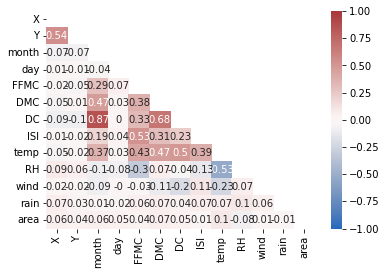

In [13]:
# Display correlation data with each feature in training data
matrix = data.corr().round(2)
mask = np.triu(np.ones_like(matrix, dtype=bool))
sns.heatmap(matrix, annot=True, vmax=1, vmin=-1,
            center=0, cmap='vlag', mask=mask)
plt.show()


Feature importance scores

Feature: 0, Score: 1.90019
Feature: 1, Score: 0.32408
Feature: 2, Score: 2.90036
Feature: 3, Score: 1.32695
Feature: 4, Score: -0.11271
Feature: 5, Score: 0.09664
Feature: 6, Score: -0.03149
Feature: 7, Score: -0.73053
Feature: 8, Score: 0.95456
Feature: 9, Score: -0.17576
Feature: 10, Score: 1.23213
Feature: 11, Score: -3.19577


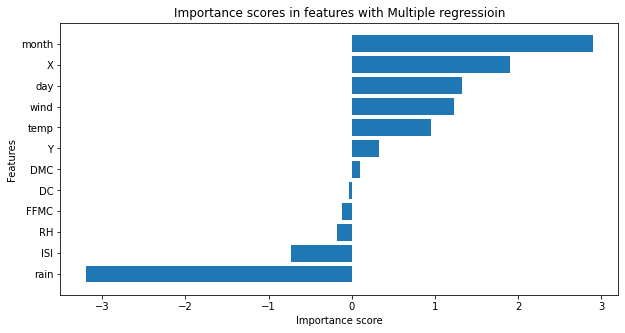

Feature: 0, Score: 0.00778
Feature: 1, Score: 0.00947
Feature: 2, Score: 0.00039
Feature: 3, Score: 0.01505
Feature: 4, Score: 0.01212
Feature: 5, Score: 0.06164
Feature: 6, Score: 0.03762
Feature: 7, Score: 0.03321
Feature: 8, Score: 0.80073
Feature: 9, Score: 0.01290
Feature: 10, Score: 0.00908
Feature: 11, Score: 0.00000


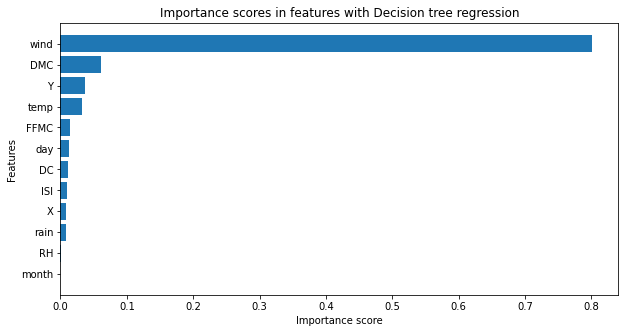

Feature: 0, Score: 0.03473
Feature: 1, Score: 0.05400
Feature: 2, Score: 0.01860
Feature: 3, Score: 0.03426
Feature: 4, Score: 0.04533
Feature: 5, Score: 0.11875
Feature: 6, Score: 0.04031
Feature: 7, Score: 0.04572
Feature: 8, Score: 0.47822
Feature: 9, Score: 0.07161
Feature: 10, Score: 0.05839
Feature: 11, Score: 0.00008


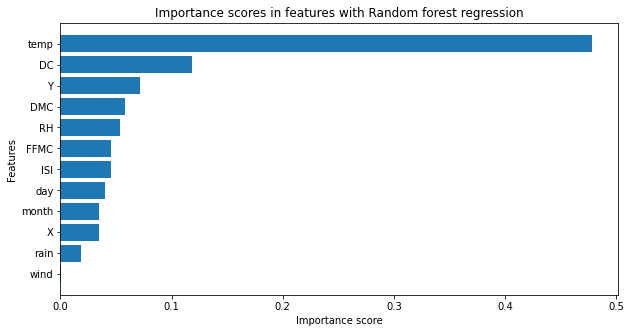

In [17]:
# Define the model to calculate feature importance score
LR = LinearRegression()
DT = DecisionTreeRegressor(criterion='squared_error')
RF = RandomForestRegressor(n_estimators=500)

models = [LR, DT, RF]
# Dictionary for models
stat_dict = {0: 'Multiple regressioin',
             1: 'Decision tree regression',
             2: 'Random forest regression',
             }

features = list(X.columns)

for i, model in enumerate(models):
    # Fit the model
    model.fit(X, y)
    # Get coefficient
    if hasattr(model, "coef_"):
        importance = model.coef_[0]
    if hasattr(model, "feature_importances_"):
        importance = model.feature_importances_

    # Summary of feature importance
    for feature, score in enumerate(importance):
        print('Feature: %0d, Score: %.5f' % (feature, score))
    imp_score = list(importance)
    imp_score, features = zip(*sorted(zip(imp_score, features)))

    fig = plt.figure(figsize=(10, 5))

    # Create a bar plot
    plt.barh(range(len(features)), imp_score)
    plt.yticks(range(len(features)), features)
    plt.xlabel('Importance score')
    plt.ylabel('Features')
    plt.title('Importance scores in features with '+stat_dict[i])
    plt.show()


Data transformation by SMOGN (smogn.smoter)

In [16]:
data_smogn = smogn.smoter(
    data = data,
    y = 'area'
)
data_smogn.reset_index(drop=True, inplace=True)

r_index: 100%|##########| 44/44 [00:00<00:00, 439.61it/s]


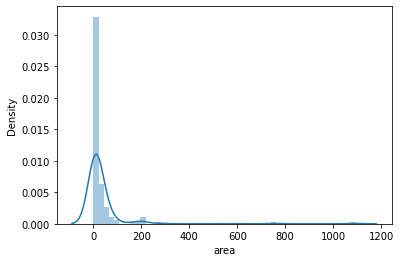

In [18]:
sns.distplot(data_smogn.area)

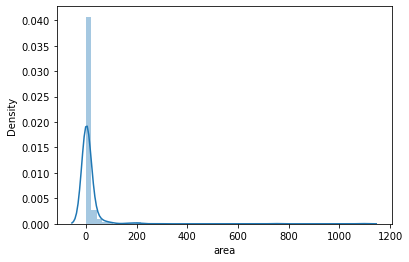

In [19]:
sns.distplot(data.area)

Create new datasets from SMOGN data with five sets of features ('STFWI', 'STM', 'FWI', 'M', 'Imp_score')

In [20]:
# Separate dataset to feature (X) and target (Y) dataframe
STFWI_columns = ['X', 'Y', 'month', 'day', 'FFMC', 'DMC', 'DC', 'ISI']
STM_columns = ['X', 'Y', 'month', 'day', 'temp', 'RH', 'wind', 'rain']
FWI_columns = ['FFMC', 'DMC', 'DC', 'ISI']
M_columns = ['temp', 'RH', 'wind', 'rain']
Imp_score_columns = ['X', 'Y', 'day', 'month', 'wind', 'temp', 'DC', 'DMC']
columns = ['area']

smogn_X = data_smogn.drop(columns=columns, axis=1)
smogn_STFWI_X = smogn_X[STFWI_columns]
smogn_STM_X = smogn_X[STM_columns]
smogn_FWI_X = smogn_X[FWI_columns]
smogn_M_X = smogn_X[M_columns]
smogn_Imp_score_X = smogn_X[Imp_score_columns]

smogn_y = data_smogn[columns]


Testing existing models with SMOGN data

In [25]:
smogn_datasets = [smogn_STFWI_X, smogn_STM_X, smogn_FWI_X, smogn_M_X, smogn_Imp_score_X]
smogn_datasets_dict = {0: 'STFWI',
                       1: 'STM',
                       2: 'FWI',
                       3: 'M',
                       4: 'Importance score'}
# Dictionary for models
models = [DR, LR, DT, RF]
models_dict = {0: 'Naive average predictor',
               1: 'Multiple regression',
               2: 'Decesion tree',
               3: 'Random forest'}

# Training for four models and four datasets
for i, model in enumerate(models):
  print('{}'.format(models_dict[i]))
  for j, dataset in enumerate(smogn_datasets):
    # MAD and RMSE score
    MAD = []
    RMSE = []

    # Use repeated K-Fold cross validator with 10 splits and 5 repeats
    for loop, (train_idx, test_idx) in enumerate(rkf.split(dataset)):
      # Create train and test datasets
      X_train, X_test = dataset.loc[train_idx], dataset.loc[test_idx]
      y_train, y_test = smogn_y.loc[train_idx], smogn_y.loc[test_idx]

      # Train each model
      model.fit(X_train, y_train)
      # Predict with test data
      y_hat = post_process(model.predict(X_test))
      # Calculate MAD and RMSE
      MAD.append(mean_absolute_error(y_test, y_hat))
      RMSE.append(mean_squared_error(y_test, y_hat, squared=False))
    print('{}: MAD: {:.3f}, RMSE: {:.3f}'.format(smogn_datasets_dict[j], np.mean(MAD), np.mean(RMSE)))

Naive average predictor
STFWI: MAD: 31.240, RMSE: 81.676
STM: MAD: 31.240, RMSE: 83.183
FWI: MAD: 31.238, RMSE: 82.453
M: MAD: 31.240, RMSE: 84.102
Importance score: MAD: 31.240, RMSE: 85.450
Multiple regression
STFWI: MAD: 31.227, RMSE: 82.578
STM: MAD: 31.328, RMSE: 83.272
FWI: MAD: 31.197, RMSE: 85.206
M: MAD: 31.325, RMSE: 86.495
Importance score: MAD: 31.308, RMSE: 85.826
Decesion tree
STFWI: MAD: 31.440, RMSE: 85.999
STM: MAD: 31.443, RMSE: 85.107
FWI: MAD: 31.483, RMSE: 83.857
M: MAD: 31.595, RMSE: 85.240
Importance score: MAD: 31.407, RMSE: 84.150
Random forest
STFWI: MAD: 31.312, RMSE: 84.820
STM: MAD: 31.342, RMSE: 85.309
FWI: MAD: 31.328, RMSE: 83.458
M: MAD: 31.336, RMSE: 81.951
Importance score: MAD: 31.325, RMSE: 83.136


Hyperparameter tuning

In [22]:
# Parameters for random forest
rf_param = { 
    'n_estimators': [100, 200, 500],
    'max_features': ['sqrt'],
    'max_depth' : [3, 4, 5],
    'criterion' :['squared_error','absolute_error']
}

# Parameters for Decision tree
dt_param = {
    'criterion': ['squared_error','absolute_error'],
    'max_depth': [2, 3, 4, 5]
}

# Parameters for bagging classifier
br_param = {
    'n_estimators': [10, 50, 100],
    'max_samples': [0.2, 0.5, 0.7, 1.0]
}

# Parameters for adaboost clasfier
abr_param = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [1.0, 1.5, 2.0]
}

# Parameters for stack classifier
sr_param = {
    'knn__n_neighbors': [i for i in range(2, 10, 2)],
    'tree__max_depth': [i for i in range(2, 10)]
}


GridSearch


In [23]:
cv=5

# Define models (bagging classifier, ada boost classifier, and stacking classifier)
BR = BaggingRegressor(base_estimator=DecisionTreeRegressor())
ABR = AdaBoostRegressor(base_estimator=DecisionTreeRegressor())
estimators = [('knn', KNeighborsRegressor()),
              ('tree', DecisionTreeRegressor())]
SR = StackingRegressor(
    estimators=estimators, final_estimator=LinearRegression(), cv=3)
DT = DecisionTreeRegressor(criterion='squared_error')
RF = RandomForestRegressor(n_estimators=500)

# Gridsearch with linear SVC to explore the best parameters
br_cv = GridSearchCV(BR, br_param, scoring='neg_root_mean_squared_error', cv=cv)
br_cv.fit(X, y)

# Gridsearch with linear SVC to explore the best parameters
abr_cv = GridSearchCV(ABR, abr_param, scoring='neg_root_mean_squared_error', cv=cv)
abr_cv.fit(X, y)

# Gridsearch with linear SVC to explore the best parameters
sr_cv = GridSearchCV(SR, sr_param, scoring='neg_root_mean_squared_error', cv=cv)
sr_cv.fit(X, y)

# Gridsearch with linear SVC to explore the best parameters
rf_cv = GridSearchCV(RF, rf_param, scoring='neg_root_mean_squared_error', cv=cv)
rf_cv.fit(X, y)

# Gridsearch with decision tree to explore the best parameters
dt_cv = GridSearchCV(DT, dt_param, scoring='neg_root_mean_squared_error', cv=cv)
dt_cv.fit(X, y)


GridSearchCV(cv=5, estimator=DecisionTreeRegressor(),
             param_grid={'criterion': ['squared_error', 'absolute_error'],
                         'max_depth': [2, 3, 4, 5]},
             scoring='neg_root_mean_squared_error')

Testing proposed datasets, hyperparameter, and models with new datasets to find the best solution

In [24]:
# Define constants
n_splits = 10
n_repeats = 5
# Create repeated K-Fold cross validator with 10 splits and 5 repeats
rkf = RepeatedKFold(n_splits=n_splits, n_repeats=n_repeats)

# Define the model to train models
grids = [dt_cv, br_cv, abr_cv, sr_cv, rf_cv]
# grids = [dt_cv, br_cv, abr_cv, sr_cv]

# Dictionary for potential models
grid_dict = {0: 'Decision Tree',
             1: 'Bagging regressor',
             2: 'AdaBoost regressor',
             3: 'Stacking regressor',
             4: 'Random forest'
             }

# Dictionary for datasets
# Separate dataset to feature (X) and target (y) DataFrame
STFWI_columns = ['X','Y','month','day','FFMC','DMC','DC','ISI']
STM_columns = ['X','Y','month','day','temp','RH','wind','rain']
FWI_columns = ['FFMC','DMC','DC','ISI']
M_columns = ['temp','RH','wind','rain']
Imp_score_columns = ['X', 'Y', 'day', 'month', 'wind', 'temp', 'DC', 'DMC']
columns = ['area']

X = data.drop(columns=columns, axis=1)
STFWI_X = X[STFWI_columns]
STM_X = X[STM_columns]
FWI_X = X[FWI_columns]
M_X = X[M_columns]
Imp_score_X = X[Imp_score_columns]
y = data[columns]

datasets = [STFWI_X, STM_X, FWI_X, M_X, Imp_score_X]
datasets_dict = {0: 'STFWI',
                 1: 'STM',
                 2: 'FWI',
                 3: 'M',
                 4: 'Importance score'}

# Displaying model performance metrics
for i, model in enumerate(grids):
  print('{} Best Params: {}'.format(grid_dict[i], model.best_params_))
  for j, dataset in enumerate(datasets):
    # MAD and RMSE scores
    MAD = []
    RMSE = []
    
    for loop, (train_idx, test_idx) in enumerate(rkf.split(dataset)):
      # Create train and test datasets
      X_train, X_test = dataset.loc[train_idx], dataset.loc[test_idx]
      y_train, y_test = y.loc[train_idx], y.loc[test_idx]

      # Train each model
      train_model = model
      train_model.fit(X_train, y_train)
      # Predict with test data
      y_hat = post_process(train_model.predict(X_test))
      # Calculate MAD and RMSE
      MAD.append(mean_absolute_error(y_test, y_hat))
      RMSE.append(mean_squared_error(y_test, y_hat, squared=False))
    print('{}: MAD: {:.3f}, RMSE: {:.3f}'.format(datasets_dict[j], np.mean(MAD), np.mean(RMSE)))


Decision Tree Best Params: {'criterion': 'absolute_error', 'max_depth': 2}
STFWI: MAD: 12.796, RMSE: 48.181
STM: MAD: 12.786, RMSE: 46.427
FWI: MAD: 12.866, RMSE: 47.430
M: MAD: 12.771, RMSE: 47.551
Importance score: MAD: 12.786, RMSE: 45.453
Bagging regressor Best Params: {'max_samples': 1.0, 'n_estimators': 50}
STFWI: MAD: 13.098, RMSE: 46.669
STM: MAD: 13.051, RMSE: 46.910
FWI: MAD: 13.082, RMSE: 45.418
M: MAD: 13.067, RMSE: 43.612
Importance score: MAD: 13.034, RMSE: 45.702
AdaBoost regressor Best Params: {'learning_rate': 1.0, 'n_estimators': 50}
STFWI: MAD: 12.922, RMSE: 46.858
STM: MAD: 12.971, RMSE: 46.516
FWI: MAD: 12.970, RMSE: 44.774
M: MAD: 12.943, RMSE: 46.940
Importance score: MAD: 12.962, RMSE: 47.059
Stacking regressor Best Params: {'knn__n_neighbors': 6, 'tree__max_depth': 5}
STFWI: MAD: 13.113, RMSE: 46.496
STM: MAD: 13.104, RMSE: 46.051
FWI: MAD: 13.114, RMSE: 46.052
M: MAD: 13.096, RMSE: 44.708
Importance score: MAD: 13.111, RMSE: 45.267
Random forest Best Params: {